LIBRARY

In [890]:
import os
import torch
import torch.nn as nn
import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import time

DATA

In [891]:
df = pd.read_csv(r'Impute_misvalues_hanoi.csv')
waterlevel_data = df['Waterlevel']
hour_data = df['Hour']
print(f"Water level size: {len(waterlevel_data)}\nHour size: {len(hour_data)}")

Water level size: 29224
Hour size: 29224


In [892]:
scaler = MinMaxScaler()
X, y = [], []
for i in range(len(waterlevel_data)-1):
    X.append(waterlevel_data[i])
    y.append(waterlevel_data[i+1])

X = np.array(X)
y = np.array(y)
train_index = int(len(X)*0.7)
val_index = int(len(X)*0.8)

# Chia train val test theo tỉ lệ 0.7 : 0.1 : 0.2; scale dữ liệu để tránh vấn đề về gradient khi tính toán
X_train, y_train = scaler.fit_transform(X[:train_index].reshape(-1, 1)).flatten(), scaler.fit_transform(y[:train_index].reshape(-1, 1)).flatten()
X_val, y_val = scaler.transform(X[train_index:val_index].reshape(-1, 1)).flatten(), scaler.transform(y[train_index:val_index].reshape(-1, 1)).flatten()
X_test, y_test = scaler.transform(X[val_index:].reshape(-1, 1)).flatten(), scaler.transform(y[val_index:].reshape(-1, 1)).flatten()

# Tăng chiều bằng unsqueeze vì input đưa vào PyTorch yêu cầu là tensor 3D
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).unsqueeze(-1)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f"Train size: {len(X_train)}\nVal size: {len(X_val)}\nTest size: {len(X_test)}")

Train size: 20456
Val size: 2922
Test size: 5845


In [893]:
NUM_EPOCHS = 20
PATIENCE = 3

RNN

In [894]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x) 
        out = self.fc(out[:, -1, :])
        return out

In [895]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [896]:
rnn = RNNModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [897]:
train_losses, val_losses = [], []
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
        # Train
        rnn.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = rnn(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation
        rnn.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = rnn(xb)
                val_loss += criterion(out, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            best_model_state = rnn.state_dict()  # lưu model tốt nhất
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                rnn.load_state_dict(best_model_state)  # load lại model tốt nhất
                break
end_time = time.time()
training_time_rnn = end_time - start_time

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([104, 1, 1])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results

Epoch 1/20, Train Loss: 0.0255, Val Loss: 0.0060
Epoch 2/20, Train Loss: 0.0165, Val Loss: 0.0041
Epoch 3/20, Train Loss: 0.0101, Val Loss: 0.0031
Epoch 4/20, Train Loss: 0.0067, Val Loss: 0.0029
Epoch 5/20, Train Loss: 0.0058, Val Loss: 0.0030
Epoch 6/20, Train Loss: 0.0057, Val Loss: 0.0030
Epoch 7/20, Train Loss: 0.0057, Val Loss: 0.0030
Early stopping at epoch 7


In [898]:
rnn.eval()
y_pred_list, y_true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = rnn(xb)
        y_pred_list.append(out.cpu())
        y_true_list.append(yb.cpu())
y_pred = torch.cat(y_pred_list).numpy().squeeze()
y_true = torch.cat(y_true_list).numpy().squeeze()

rnn_mse = mean_squared_error(y_true, y_pred)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(y_true, y_pred)
rnn_r2 = r2_score(y_true, y_pred)
rnn_nse = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
print(r'RNN RESULT')    
print(f"\nMSE: {rnn_mse:.4f}\nRMSE: {rnn_rmse:.4f}\nMAE: {rnn_mae:.4f}\nR2: {rnn_r2:.4f}\nNSE: {rnn_nse:.4f}\nTraining time: {training_time_rnn:.0f} seconds")

RNN RESULT

MSE: 0.0004
RMSE: 0.0202
MAE: 0.0160
R2: 0.9808
NSE: 0.9808
Training time: 4 seconds


In [899]:
y_pred_original_rnn = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_true_original_rnn = scaler.inverse_transform(y_true.reshape(-1, 1))

LSTM

In [900]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [901]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [902]:
lstm = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

In [903]:
train_losses, val_losses = [], []
best_val_loss = float('inf')
start_time = time.time()

for epoch in range(NUM_EPOCHS):
        # Train
        lstm.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = lstm(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
        
        # Validation
        lstm.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = lstm(xb)
                val_loss += criterion(out, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            best_model_state = lstm.state_dict()  # lưu model tốt nhất
        else:
            wait += 1
            if wait >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                lstm.load_state_dict(best_model_state)  # load lại model tốt nhất
                break
end_time = time.time()
training_time_lstm = end_time - start_time

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([104, 1, 1])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([106, 1, 1])) that is different to the input size (torch.Size([106, 1])). This will likely lead to incorrect results

Epoch 1/20, Train Loss: 0.0283, Val Loss: 0.0078
Epoch 2/20, Train Loss: 0.0213, Val Loss: 0.0066
Epoch 3/20, Train Loss: 0.0166, Val Loss: 0.0048
Epoch 4/20, Train Loss: 0.0108, Val Loss: 0.0032
Epoch 5/20, Train Loss: 0.0069, Val Loss: 0.0029
Epoch 6/20, Train Loss: 0.0058, Val Loss: 0.0029
Epoch 7/20, Train Loss: 0.0057, Val Loss: 0.0029
Epoch 8/20, Train Loss: 0.0057, Val Loss: 0.0029
Early stopping at epoch 8


In [904]:
lstm.eval()
y_pred_list, y_true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = lstm(xb)
        y_pred_list.append(out.cpu())
        y_true_list.append(yb.cpu())
y_pred = torch.cat(y_pred_list).numpy().squeeze()
y_true = torch.cat(y_true_list).numpy().squeeze()

lstm_mse = mean_squared_error(y_true, y_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_true, y_pred)
lstm_r2 = r2_score(y_true, y_pred)
lstm_nse = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
print(r'LSTM RESULT')    
print(f"\nMSE: {lstm_mse:.4f}\nRMSE: {lstm_rmse:.4f}\nMAE: {lstm_mae:.4f}\nR2: {lstm_r2:.4f}\nNSE: {lstm_nse:.4f}\nTraining time: {training_time_lstm:.0f} seconds")

LSTM RESULT

MSE: 0.0004
RMSE: 0.0212
MAE: 0.0169
R2: 0.9788
NSE: 0.9788
Training time: 4 seconds


In [905]:
y_pred_original_lstm = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_true_original_lstm = scaler.inverse_transform(y_true.reshape(-1, 1))

TRANSFORMER

In [906]:
sequence_length = 8
scaler = MinMaxScaler()

# Tạo sequence
X, y = [], []
for i in range(len(waterlevel_data) - sequence_length):
    X.append(waterlevel_data[i:i + sequence_length])
    y.append(waterlevel_data[i + sequence_length])
X = np.array(X)
y = np.array(y).reshape(-1, 1)

# Chia train / val / test
train_idx = int(len(X) * 0.7)
val_idx = int(len(X) * 0.8)

# Chỉ fit trên train để tránh data leakage
X_train = scaler.fit_transform(X[:train_idx].reshape(-1, 1)).reshape(-1, sequence_length)
y_train = scaler.fit_transform(y[:train_idx])
X_val = scaler.transform(X[train_idx:val_idx].reshape(-1, 1)).reshape(-1, sequence_length)
y_val = scaler.transform(y[train_idx:val_idx])
X_test = scaler.transform(X[val_idx:].reshape(-1, 1)).reshape(-1, sequence_length)
y_test = scaler.transform(y[val_idx:])

# Chuyển sang tensor và tăng chiều cho Transformer (batch, seq_len, feature)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [907]:
# Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [908]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x[:, -1, :]  # Lấy output timestep cuối
        return self.fc_out(x)

In [909]:
torch.cuda.empty_cache()
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [910]:
# Huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

best_val_loss = float('inf')
wait = 0

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    transformer.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = transformer(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
    
    # Validation
    transformer.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = transformer(xb)
            val_loss += criterion(out, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_model_state = transformer.state_dict()  # lưu model tốt nhất
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            transformer.load_state_dict(best_model_state)  # load lại model tốt nhất
            break

end_time = time.time()
training_time_transformer = end_time - start_time


Epoch 1/20, Train Loss: 0.0057, Val Loss: 0.0027
Epoch 2/20, Train Loss: 0.0057, Val Loss: 0.0007
Epoch 3/20, Train Loss: 0.0057, Val Loss: 0.0013
Epoch 4/20, Train Loss: 0.0057, Val Loss: 0.0006
Epoch 5/20, Train Loss: 0.0057, Val Loss: 0.0007
Epoch 6/20, Train Loss: 0.0057, Val Loss: 0.0013
Epoch 7/20, Train Loss: 0.0057, Val Loss: 0.0004
Epoch 8/20, Train Loss: 0.0057, Val Loss: 0.0004
Epoch 9/20, Train Loss: 0.0057, Val Loss: 0.0004
Epoch 10/20, Train Loss: 0.0057, Val Loss: 0.0004
Epoch 11/20, Train Loss: 0.0057, Val Loss: 0.0007
Epoch 12/20, Train Loss: 0.0057, Val Loss: 0.0002
Epoch 13/20, Train Loss: 0.0057, Val Loss: 0.0002
Epoch 14/20, Train Loss: 0.0057, Val Loss: 0.0002
Epoch 15/20, Train Loss: 0.0057, Val Loss: 0.0002
Early stopping at epoch 15


In [911]:
transformer.eval()
y_pred_list, y_true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = transformer(xb)
        y_pred_list.append(out.cpu())
        y_true_list.append(yb.cpu())
y_pred = torch.cat(y_pred_list).numpy().squeeze()
y_true = torch.cat(y_true_list).numpy().squeeze()

transformer_mse = mean_squared_error(y_true, y_pred)
transformer_rmse = np.sqrt(transformer_mse)
transformer_mae = mean_absolute_error(y_true, y_pred)
transformer_r2 = r2_score(y_true, y_pred)
transformer_nse = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
print(r'TRANSFORMER RESULT')    
print(f"\nMSE: {transformer_mse:.4f}\nRMSE: {transformer_rmse:.4f}\nMAE: {transformer_mae:.4f}\nR2: {transformer_r2:.4f}\nNSE: {transformer_nse:.4f}\nTraining time: {training_time_transformer:.0f} seconds")

TRANSFORMER RESULT

MSE: 0.0003
RMSE: 0.0186
MAE: 0.0143
R2: 0.9837
NSE: 0.9837
Training time: 20 seconds


In [912]:
y_pred_original_transformer = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_true_original_transformer = scaler.inverse_transform(y_true.reshape(-1, 1))

COMPARISION

In [913]:
results = pd.DataFrame({
    r"Model": list([r'RNN', r'LSTM', r'Transformer']),
    r"R2 Score": list([rnn_r2, lstm_r2, transformer_r2]),
    r"MSE": list([rnn_mse, lstm_mse, transformer_mse]),
    r"RMSE": list([rnn_rmse, lstm_rmse, transformer_rmse]),
    r"MAE": list([rnn_mae, lstm_mae, transformer_mae]),
    r"NSE": list([rnn_nse, lstm_nse, transformer_nse]),
    r"Training time (s)": list([training_time_rnn, training_time_lstm, training_time_transformer]),
})
results

,Model,R2 Score,MSE,RMSE,MAE,NSE,Training time (s)
0,RNN,0.980755,0.000406,0.020159,0.015953,0.980755,3.975353
1,LSTM,0.978777,0.000448,0.021170,0.016905,0.978777,4.142642
2,Transformer,0.983686,0.000345,0.018561,0.014347,0.983686,19.640559


In [914]:
df = pd.DataFrame({
    r"Metrics": list([r"R2 Score", r"MSE", r"RMSE", r"MAE",  r"NSE"]),
    r"RNN": list([rnn_r2, rnn_mse, rnn_rmse, rnn_mae, rnn_nse]),
    r"LSTM": list([lstm_r2, lstm_mse, lstm_rmse, lstm_mae, lstm_nse]),
    r"Transformer": list([transformer_r2, transformer_mse, transformer_rmse, transformer_mae, transformer_nse])
})

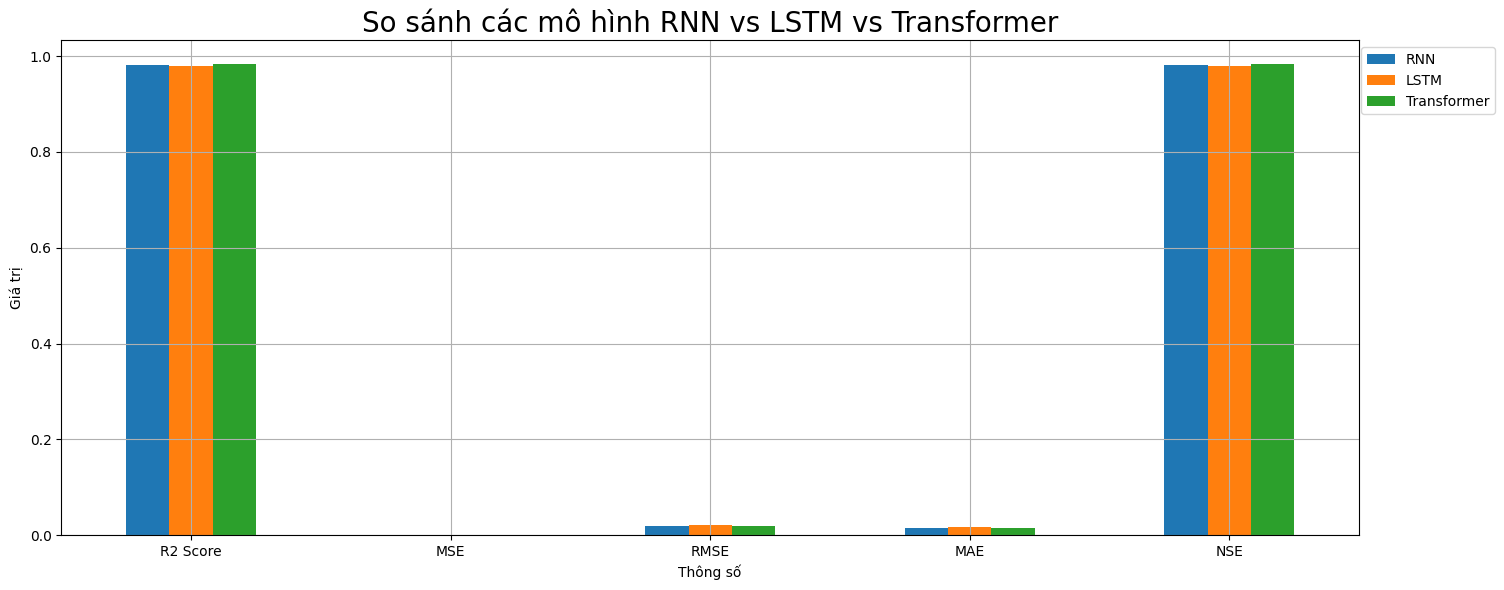

In [915]:
df.plot(kind = r'bar', figsize = (15, 6))
plt.grid(True)
plt.title(r'So sánh các mô hình RNN vs LSTM vs Transformer', fontsize = 20)
plt.xlabel(r'Thông số')
plt.xticks(ticks=range(len(df["Metrics"])), labels = df["Metrics"], rotation = 0)
plt.ylabel(r'Giá trị')
plt.legend(bbox_to_anchor = (1.11, 1))
plt.tight_layout()

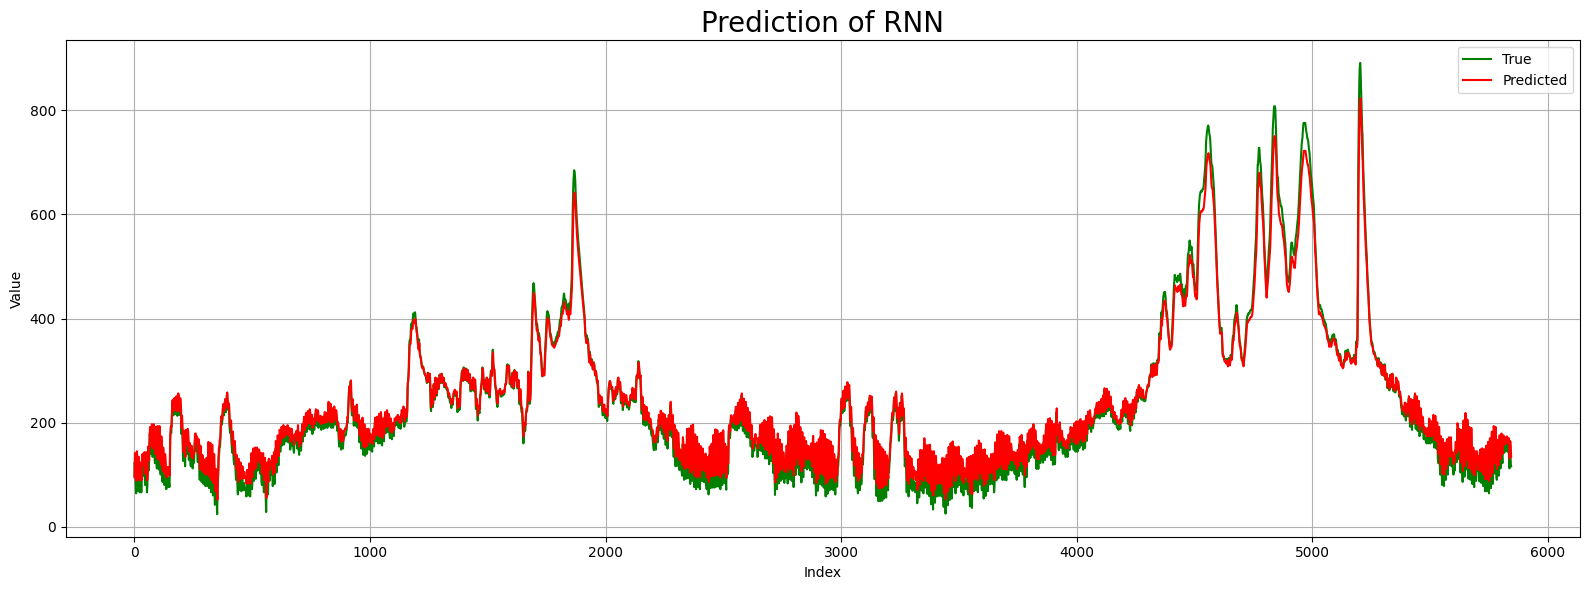

In [916]:
plt.figure(figsize = (16, 6))
plt.plot(y_true_original_rnn, color = 'green', label='True')
plt.plot(y_pred_original_rnn, color = 'red', label='Predicted')
plt.title(r'Prediction of RNN', fontsize = 20)
plt.xlabel(r'Index')
plt.ylabel(r'Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

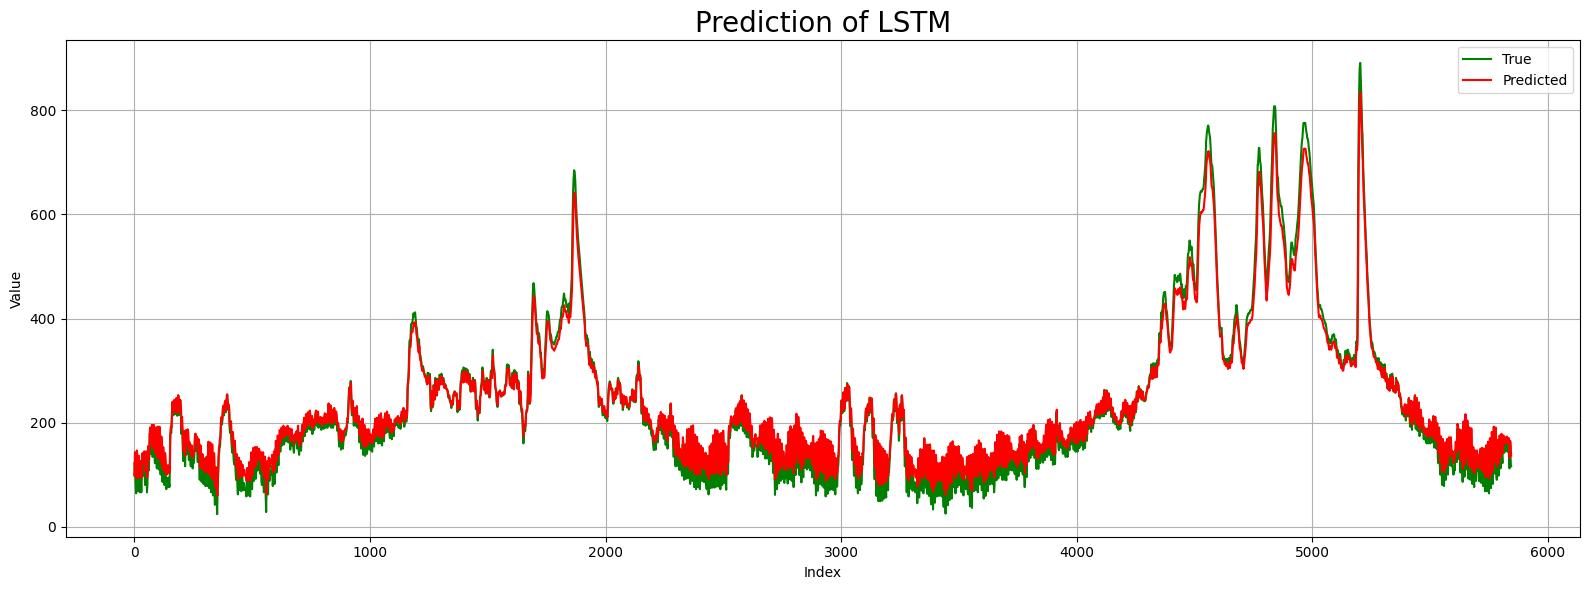

In [917]:
plt.figure(figsize = (16, 6))
plt.plot(y_true_original_lstm, color = 'green', label='True')
plt.plot(y_pred_original_lstm, color = 'red', label='Predicted')
plt.title(r'Prediction of LSTM', fontsize = 20)
plt.xlabel(r'Index')
plt.ylabel(r'Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

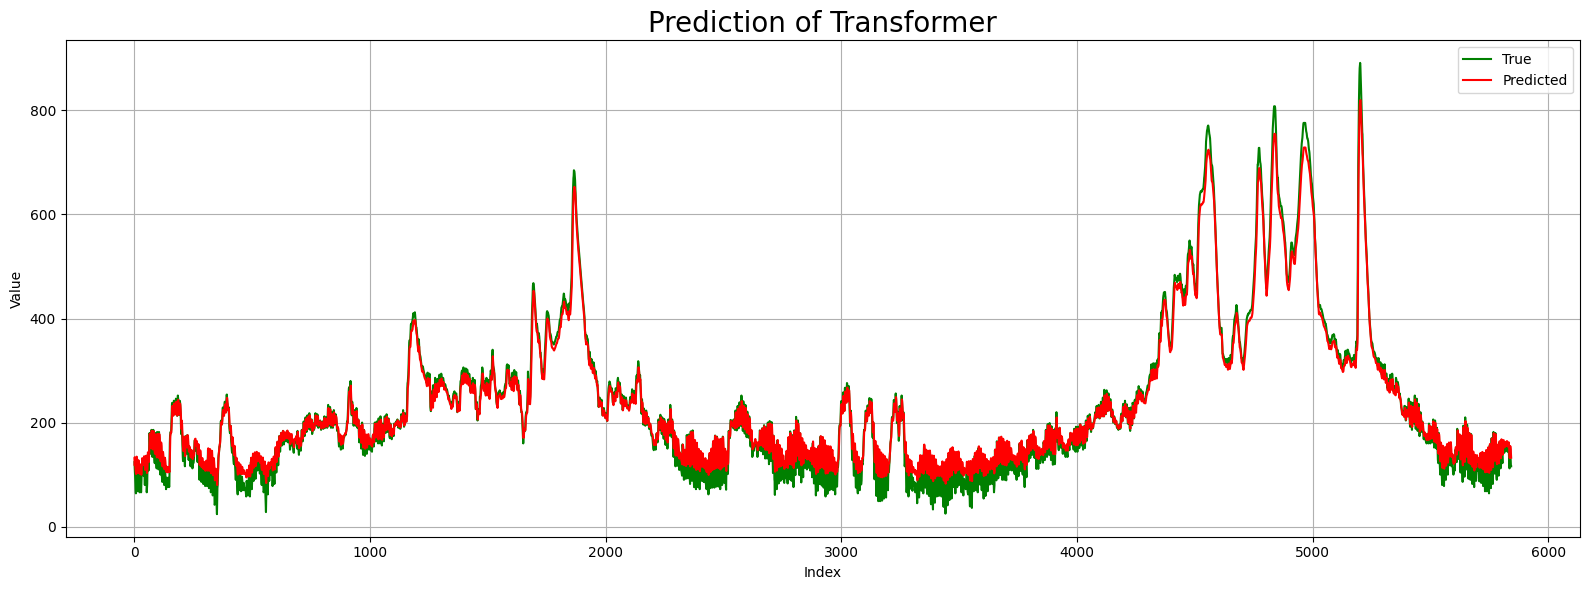

In [918]:
plt.figure(figsize = (16, 6))
plt.plot(y_true_original_transformer, color = 'green', label='True')
plt.plot(y_pred_original_transformer, color = 'red', label='Predicted')
plt.title(r'Prediction of Transformer', fontsize = 20)
plt.xlabel(r'Index')
plt.ylabel(r'Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

NHẬN XÉT:
- RNN và LSTM nhạy cảm với scale của dữ liệu, Transformer nhạy cảm với độ dài chuỗi đưa vào
- Thời gian tính toán của Transformer dài nhất, rồi đến LSTM và nhanh nhất là RNN
- Nên scale Min-Max thay vì Standard do vấn đề về gradient của RNN và LSTM